In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import pickle

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [53]:
# ===== CONFIGURAZIONE =====
# Seleziona l'appliance da disaggregare
# Appliances disponibili:
# - chargingstation_socket, dishwasher, dryer, garagecabinet
# - heatpump, heatpump_controller, oven, rainwaterpump
# - rangehood, smappeecharger, stove, washingmachine

TARGET_APPLIANCE = 'heatpump'  # Cambia qui per selezionare un'altra appliance

# Percorso base dei dati
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")
APPLIANCE_PATH = os.path.join(DATA_BASE_PATH, TARGET_APPLIANCE)

# Lista delle appliances disponibili
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Appliances disponibili: {available_appliances}")

# Verifica che l'appliance selezionata esista
assert TARGET_APPLIANCE in available_appliances, f"Appliance '{TARGET_APPLIANCE}' non trovata!"

# Carica i dati preprocessati
X_train = np.load(os.path.join(APPLIANCE_PATH, "X_train.npy"))
X_val = np.load(os.path.join(APPLIANCE_PATH, "X_val.npy"))
X_test = np.load(os.path.join(APPLIANCE_PATH, "X_test.npy"))
y_train = np.load(os.path.join(APPLIANCE_PATH, "y_train.npy"))
y_val = np.load(os.path.join(APPLIANCE_PATH, "y_val.npy"))
y_test = np.load(os.path.join(APPLIANCE_PATH, "y_test.npy"))

# Carica lo scaler se disponibile
scaler_path = os.path.join(DATA_BASE_PATH, "scaler.pkl")
if os.path.exists(scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler caricato da {scaler_path}")
else:
    scaler = None
    print("⚠️ Scaler non trovato, i dati potrebbero già essere normalizzati")

print(f"\n✓ Dataset '{TARGET_APPLIANCE}' caricato:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Determina parametri dai dati
# X shape: (samples, seq_len, num_features)
# y shape: (samples, seq_len, 1)
window_size = X_train.shape[1]  # 99 timesteps
num_input_features = X_train.shape[2]  # 7 features

print(f"\n✓ Window size: {window_size} timesteps")
print(f"✓ Input features: {num_input_features}")

Appliances disponibili: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
✓ Scaler caricato da ..\data\processed\15min\model_ready\scaler.pkl

✓ Dataset 'heatpump' caricato:
  X_train: (24094, 99, 7) | y_train: (24094, 99, 1)
  X_val:   (5374, 99, 7) | y_val:   (5374, 99, 1)
  X_test:  (5278, 99, 7) | y_test:  (5278, 99, 1)

✓ Window size: 99 timesteps
✓ Input features: 7


## 3. EXPLORATORY DATA ANALYSIS

In [54]:
# Analizza i dati caricati
print("=== STATISTICHE DATASET ===")
print(f"\n📊 Input (X) - {num_input_features} features:")
print(f"  Train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"  Val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"  Test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\n📊 Statistiche per feature (X_train):")
for i in range(num_input_features):
    feat_data = X_train[:, :, i]
    print(f"  Feature {i}: min={feat_data.min():.4f}, max={feat_data.max():.4f}, mean={feat_data.mean():.4f}")

print(f"\n📊 Target (y - {TARGET_APPLIANCE}):")
print(f"  Train: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"  Val:   min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
print(f"  Test:  min={y_test.min():.4f}, max={y_test.max():.4f}, mean={y_test.mean():.4f}")

print(f"\n📊 Dimensioni:")
print(f"  Sequenze totali: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Train: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")

=== STATISTICHE DATASET ===

📊 Input (X) - 7 features:
  Train: min=0.0000, max=1.0000, mean=0.4376
  Val:   min=0.0000, max=1.0000, mean=0.4455
  Test:  min=0.0000, max=1.0000, mean=0.4468

📊 Statistiche per feature (X_train):
  Feature 0: min=0.0000, max=1.0000, mean=0.1040
  Feature 1: min=0.0000, max=1.0000, mean=0.5000
  Feature 2: min=0.0000, max=1.0000, mean=0.5000
  Feature 3: min=0.0000, max=1.0000, mean=0.5018
  Feature 4: min=0.0000, max=1.0000, mean=0.4734
  Feature 5: min=0.0000, max=1.0000, mean=0.4841
  Feature 6: min=0.0000, max=1.0000, mean=0.4999

📊 Target (y - heatpump):
  Train: min=0.0000, max=1.0000, mean=0.1152
  Val:   min=0.0006, max=0.9938, mean=0.1375
  Test:  min=0.0006, max=0.9986, mean=0.1376

📊 Dimensioni:
  Sequenze totali: 34746
  Train: 24094 (69.3%)
  Val:   5374 (15.5%)
  Test:  5278 (15.2%)


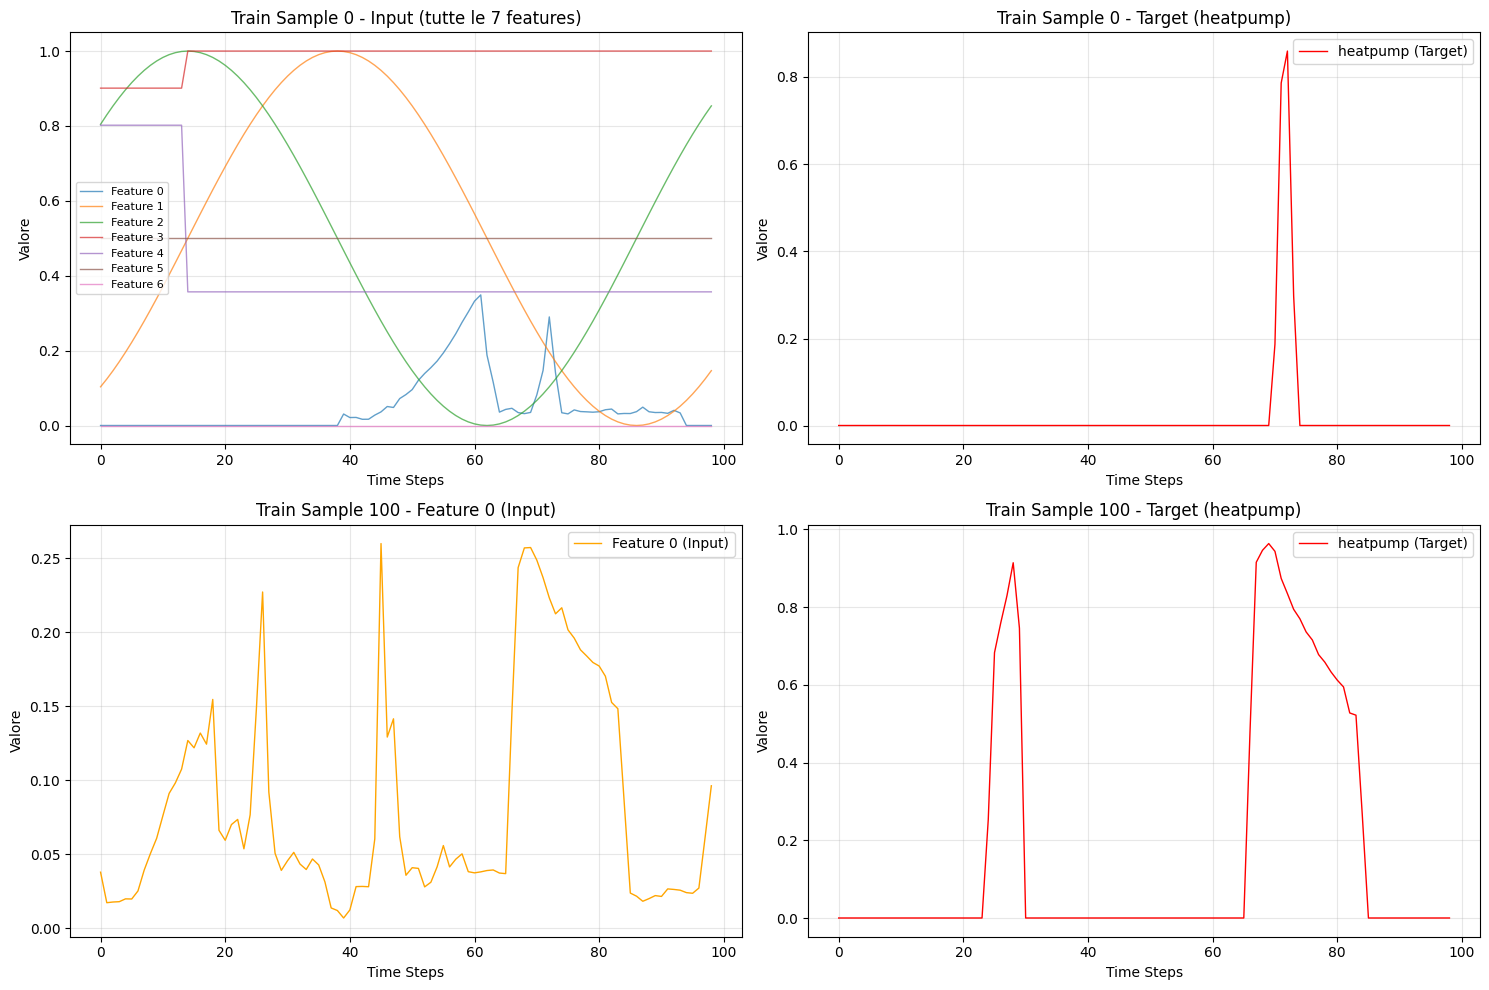

In [55]:
# Visualizza alcune sequenze di esempio
sample_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot di tutte le features di input per il primo sample
ax = axes[0, 0]
for i in range(num_input_features):
    ax.plot(X_train[sample_idx, :, i], linewidth=1, label=f'Feature {i}', alpha=0.7)
ax.set_title(f'Train Sample {sample_idx} - Input (tutte le {num_input_features} features)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Target per il primo sample
ax = axes[0, 1]
ax.plot(y_train[sample_idx, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

# Seconda sequenza - solo feature 0 (assumendo sia l'aggregate principale)
sample_idx_2 = min(100, len(X_train)-1)
ax = axes[1, 0]
ax.plot(X_train[sample_idx_2, :, 0], linewidth=1, color='orange', label='Feature 0 (Input)')
ax.set_title(f'Train Sample {sample_idx_2} - Feature 0 (Input)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
ax.plot(y_train[sample_idx_2, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx_2} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. DATA NORMALIZATION & SEQUENCE CREATION

In [56]:
# I dati sono già preprocessati e pronti per il training
# Shape: X -> (samples, seq_len, num_features), y -> (samples, seq_len, 1)

print(f"✓ Dati pronti per il training")
print(f"  X_train shape: {X_train.shape} -> (samples, seq_len={window_size}, features={num_input_features})")
print(f"  y_train shape: {y_train.shape} -> (samples, seq_len={window_size}, target=1)")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

✓ Dati pronti per il training
  X_train shape: (24094, 99, 7) -> (samples, seq_len=99, features=7)
  y_train shape: (24094, 99, 1) -> (samples, seq_len=99, target=1)
  X_val shape: (5374, 99, 7)
  y_val shape: (5374, 99, 1)
  X_test shape: (5278, 99, 7)
  y_test shape: (5278, 99, 1)


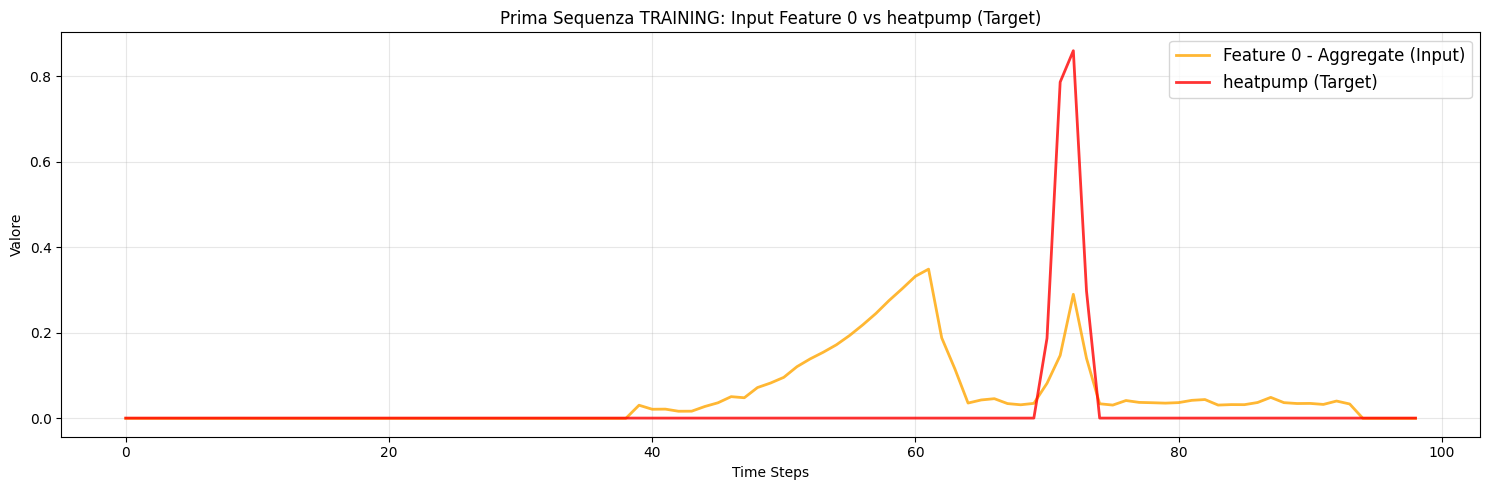

In [57]:
# Visualizza il confronto Input vs Target per la prima sequenza di TRAINING
plt.figure(figsize=(15, 5))
# Plot feature 0 (assumendo sia l'aggregate/consumo totale)
plt.plot(range(window_size), X_train[0, :, 0], linewidth=2, color='orange', label='Feature 0 - Aggregate (Input)', alpha=0.8)
plt.plot(range(window_size), y_train[0, :, 0], linewidth=2, color='red', label=f'{TARGET_APPLIANCE} (Target)', alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Valore')
plt.title(f'Prima Sequenza TRAINING: Input Feature 0 vs {TARGET_APPLIANCE} (Target)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - CNN Seq2Seq

In [58]:
# Modello U-Net 1D per NILM - adattato per multiple features di input

class UNet1D(nn.Module):
    """
    U-Net 1D per disaggregazione energetica.
    Le skip connections preservano i dettagli temporali dei picchi.
    Supporta multiple features di input e sequenze di lunghezza arbitraria.
    """
    def __init__(self, input_channels=7, base_channels=64):
        super(UNet1D, self).__init__()
        
        # Encoder (downsampling path)
        self.enc1 = self._conv_block(input_channels, base_channels)
        self.enc2 = self._conv_block(base_channels, base_channels * 2)
        self.enc3 = self._conv_block(base_channels * 2, base_channels * 4)
        self.enc4 = self._conv_block(base_channels * 4, base_channels * 8)
        
        # Bottleneck
        self.bottleneck = self._conv_block(base_channels * 8, base_channels * 16)
        
        # Decoder (upsampling path) con skip connections
        self.dec4 = self._conv_block(base_channels * 16 + base_channels * 8, base_channels * 8)
        self.dec3 = self._conv_block(base_channels * 8 + base_channels * 4, base_channels * 4)
        self.dec2 = self._conv_block(base_channels * 4 + base_channels * 2, base_channels * 2)
        self.dec1 = self._conv_block(base_channels * 2 + base_channels, base_channels)
        
        # Output
        self.output = nn.Sequential(
            nn.Conv1d(base_channels, 1, kernel_size=1),
            nn.ReLU()  # ReLU invece di Sigmoid - output >= 0
        )
        
        # Pooling
        self.pool = nn.MaxPool1d(2)
        
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.LeakyReLU(0.1),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25)  # più dropout per mitigare overfitting
        )
    
    def _upsample_and_concat(self, x, skip):
        """Upsample x to match skip's size, then concatenate"""
        # Upsample to match skip connection size
        x = nn.functional.interpolate(x, size=skip.shape[2], mode='linear', align_corners=True)
        return torch.cat([x, skip], dim=1)
    
    def forward(self, x):
        # x: (batch, seq_len, num_features) -> (batch, num_features, seq_len)
        original_len = x.shape[1]
        x = x.transpose(1, 2)
        
        # Encoder con salvataggio per skip connections
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder con skip connections (usando interpolazione per allineare le dimensioni)
        d4 = self.dec4(self._upsample_and_concat(b, e4))
        d3 = self.dec3(self._upsample_and_concat(d4, e3))
        d2 = self.dec2(self._upsample_and_concat(d3, e2))
        d1 = self.dec1(self._upsample_and_concat(d2, e1))
        
        # Output
        out = self.output(d1)
        
        # Assicurati che l'output abbia la stessa lunghezza dell'input
        if out.shape[2] != original_len:
            out = nn.functional.interpolate(out, size=original_len, mode='linear', align_corners=True)
        
        # (batch, 1, seq_len) -> (batch, seq_len, 1)
        return out.transpose(1, 2)

print("✓ Modello U-Net 1D definito")
print(f"  - Input channels: {num_input_features} features")
print("  - Skip connections per preservare dettagli temporali")
print("  - Encoder-Decoder simmetrico")
print("  - Supporta sequenze di lunghezza arbitraria")
print("  - ReLU output (valori >= 0)")

✓ Modello U-Net 1D definito
  - Input channels: 7 features
  - Skip connections per preservare dettagli temporali
  - Encoder-Decoder simmetrico
  - Supporta sequenze di lunghezza arbitraria
  - ReLU output (valori >= 0)


## 6. DATA PREPARATION FOR TRAINING

In [59]:
class EnergyDataset(Dataset):
    def __init__(self, X, y, augment=False, noise_std=0.01):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.augment = augment
        self.noise_std = noise_std
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = torch.clamp(x + noise, 0.0, 1.0)  # dati già normalizzati
        return x, self.y[idx]

print("✓ EnergyDataset definito (opz. noise augmentation)")

✓ EnergyDataset definito (opz. noise augmentation)


## 7. TRAINING

In [ ]:
# ===== CONFIGURAZIONE E TRAINING =====

batch_size = 16
base_channels = 32  # capacità ridotta per limitare overfitting
num_epochs = 180
learning_rate = 0.0008
noise_std = 0.015  # rumore gaussiano per il solo training

# Dataset
train_dataset = EnergyDataset(X_train, y_train, augment=True, noise_std=noise_std)
val_dataset = EnergyDataset(X_val, y_val, augment=False)
test_dataset = EnergyDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Sequenze TRAINING: {len(X_train):,}")
print(f"Sequenze VALIDATION: {len(X_val):,}")
print(f"Sequenze TEST: {len(X_test):,}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Noise std (train only): {noise_std}")

# Setup modello U-Net con il corretto numero di input channels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1D(input_channels=num_input_features, base_channels=base_channels).to(device)
print(f"Parametri: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input channels: {num_input_features}")

# === LOSS FUNCTION MIGLIORATA ===
class NILMLoss(nn.Module):
    """
    Loss per NILM con focus estremo sui picchi.
    """
    def __init__(self, alpha=0.5):
        super(NILMLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none')
        
    def forward(self, pred, target):
        # MSE base
        mse = self.mse(pred, target)
        
        # Peso adattivo: pesa MOLTO di più dove il target è alto
        # Normalizza il target per avere pesi tra 1 e 100
        weight = 1.0 + 99.0 * (target / (target.max() + 1e-8))
        
        # Loss pesata
        weighted_loss = (mse * weight).mean()
        
        # Penalità per sotto-predizioni (quando target > pred)
        under_pred = torch.clamp(target - pred, min=0)
        under_penalty = (under_pred ** 2 * weight * 2).mean()
        
        # MAE per stabilità
        mae = torch.abs(pred - target).mean()
        
        return weighted_loss + under_penalty + self.alpha * mae

criterion = NILMLoss(alpha=0.3)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)

print("✓ NILMLoss configurata (peso adattivo sui picchi)")
print("✓ CosineAnnealingWarmRestarts scheduler attivo")

Sequenze TRAINING: 24,094
Sequenze VALIDATION: 5,374
Sequenze TEST: 5,278
Device: GPU
Noise std (train only): 0.015
Parametri: 1,477,681
Input channels: 7
✓ NILMLoss configurata (peso adattivo sui picchi)
✓ CosineAnnealingWarmRestarts scheduler attivo


In [61]:
import time

# Training loop con validation
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience, patience_counter = 5, 0  # meno pazienza per fermare prima
lr_history = []

print(f"🚀 Training U-Net ({num_epochs} epoche, early stopping patience={patience})\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        pred = model(inp)
        loss = criterion(pred, tgt)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inp, tgt in val_loader:
            inp, tgt = inp.to(device), tgt.to(device)
            pred = model(inp)
            val_loss += criterion(pred, tgt).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Early stopping basato su validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f} | {time.time()-start:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\n✓ Training completato! Best validation loss: {best_val_loss:.6f}")

🚀 Training U-Net (180 epoche, early stopping patience=5)

Epoch  10 | Train Loss: 0.179506 | Val Loss: 1.699006 | LR: 0.000600 | 16.8s

⚠️ Early stopping at epoch 10

✓ Training completato! Best validation loss: 1.477076


## 8. RESULTS & VISUALIZATION

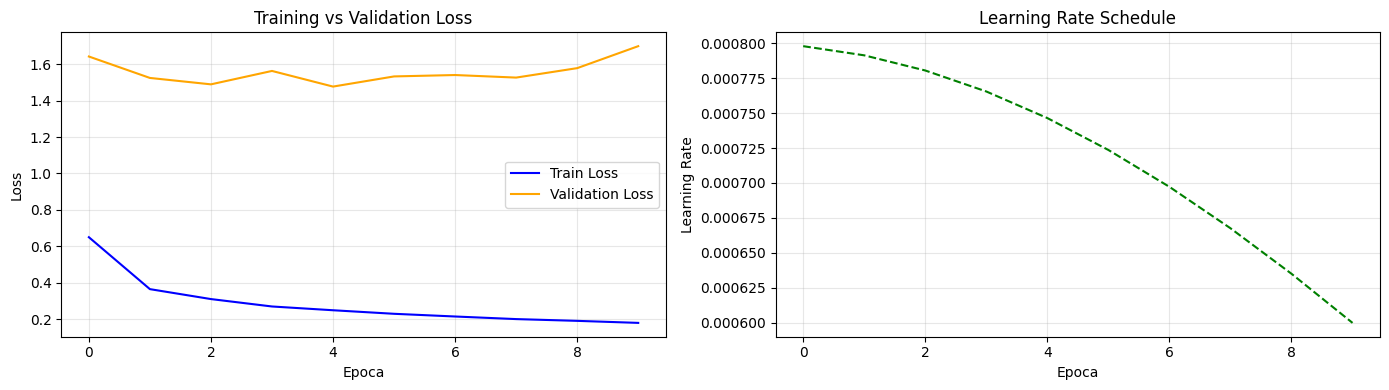

Train Loss: 0.6500 → 0.1795
Val Loss: 1.6423 → 1.6990 (best: 1.4771)


In [62]:
# Plot training e validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Validation Loss', color='orange')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning Rate
axes[1].plot(lr_history, linestyle='--', color='green', label='Learning Rate')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} (best: {best_val_loss:.4f})")

In [63]:
# Salva il modello
model_dir = os.path.join("..", "models")
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, f"unet_seq2seq_{TARGET_APPLIANCE}_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'base_channels': base_channels,
        'window_size': window_size,
        'num_input_features': num_input_features,
        'target_appliance': TARGET_APPLIANCE
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}, model_path)
print(f"✓ Modello salvato: {model_path}")

✓ Modello salvato: ..\models\unet_seq2seq_heatpump_model.pth


## 9. INFERENCE & EVALUATION

In [69]:
# Valutazione su TEST SET
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_idx = 100  # Sequenza di test da visualizzare

with torch.no_grad():
    inp = torch.FloatTensor(X_test[test_idx]).unsqueeze(0).to(device)
    pred = model(inp).cpu().numpy().squeeze()
    actual = y_test[test_idx].squeeze()

# Calcola metriche
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f"📊 Metriche TEST (sequenza {test_idx}):")
print(f"  MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

📊 Metriche TEST (sequenza 100):
  MSE: 0.003998 | MAE: 0.028947 | R²: 0.9351


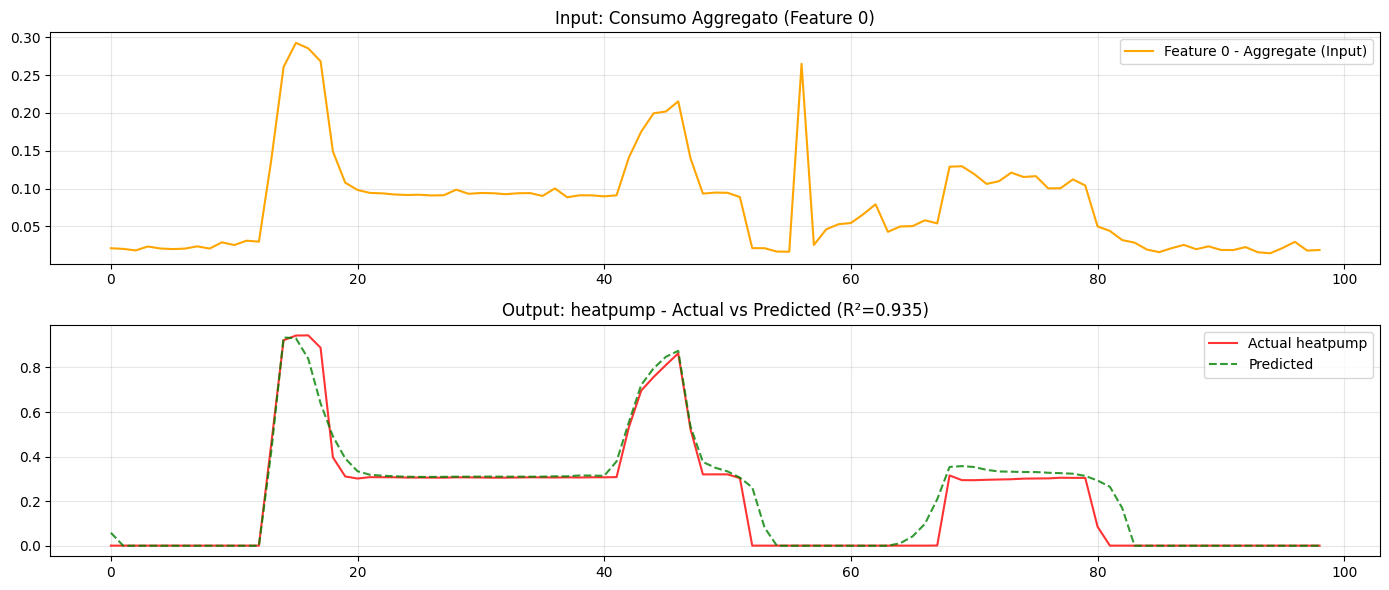

: 

In [ ]:
# Visualizzazione predizioni vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Input - mostra Feature 0 (assumendo sia aggregate)
input_data = X_test[test_idx, :, 0]  # Prima feature
axes[0].plot(input_data, color='orange', label='Feature 0 - Aggregate (Input)')
axes[0].set_title('Input: Consumo Aggregato (Feature 0)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Predizione vs Actual
axes[1].plot(actual, color='red', label=f'Actual {TARGET_APPLIANCE}', alpha=0.8)
axes[1].plot(pred, color='green', linestyle='--', label='Predicted', alpha=0.8)
axes[1].set_title(f'Output: {TARGET_APPLIANCE} - Actual vs Predicted (R²={r2:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⚠️ R² negativo per sequenza 822: -1.0248
⚠️ R² negativo per sequenza 1933: -1.1532
⚠️ R² negativo per sequenza 1934: -1.2833
⚠️ R² negativo per sequenza 1935: -1.3728
⚠️ R² negativo per sequenza 1936: -1.4606
⚠️ R² negativo per sequenza 1937: -1.5486
⚠️ R² negativo per sequenza 1938: -1.6203
⚠️ R² negativo per sequenza 1939: -1.7429
⚠️ R² negativo per sequenza 1940: -1.6092
⚠️ R² negativo per sequenza 1941: -1.7439
⚠️ R² negativo per sequenza 1942: -1.7070
⚠️ R² negativo per sequenza 1943: -1.6220
⚠️ R² negativo per sequenza 1944: -1.4570
⚠️ R² negativo per sequenza 1945: -1.4601
⚠️ R² negativo per sequenza 1946: -1.5103
⚠️ R² negativo per sequenza 1947: -1.5216
⚠️ R² negativo per sequenza 1948: -1.4435
⚠️ R² negativo per sequenza 1949: -1.5901
⚠️ R² negativo per sequenza 1950: -1.6494
⚠️ R² negativo per sequenza 1951: -1.5260
⚠️ R² negativo per sequenza 1952: -1.4221
⚠️ R² negativo per sequenza 1953: -1.3358
⚠️ R² negativo per sequenza 1954: -1.1585
⚠️ R² negativo per sequenza 1955: -

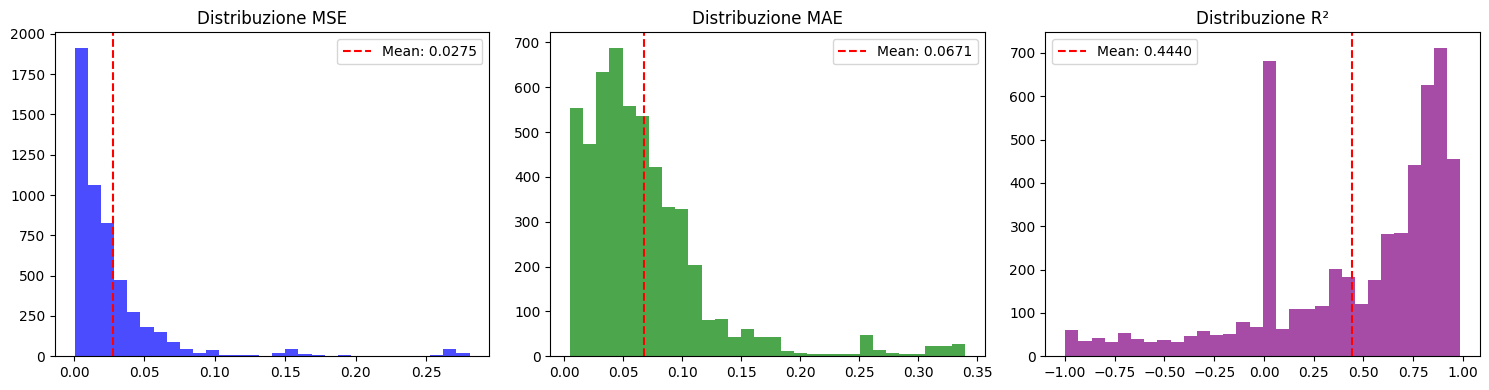

In [66]:
# Valutazione su TUTTO il test set
metrics = {'mse': [], 'mae': [], 'r2': []}

model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        inp = torch.FloatTensor(X_test[i]).unsqueeze(0).to(device)
        pred = model(inp).cpu().numpy().squeeze()
        actual = y_test[i].squeeze()
        
        metrics['mse'].append(mean_squared_error(actual, pred))
        metrics['mae'].append(mean_absolute_error(actual, pred))
        rscore = r2_score(actual, pred)
        if rscore < -1:
            print(f"⚠️ R² negativo per sequenza {i}: {rscore:.4f}")
            rscore = 0.0  # Considera R² negativo come 0 per stabilità
        if rscore > 1:
            print(f"⚠️ R² maggiore di 1 per sequenza {i}: {rscore:.4f}")
            rscore = 1.0  # Limita R² a 1
        metrics['r2'].append(rscore)


print(f"📊 Metriche su TUTTO il TEST SET ({len(X_test)} sequenze):")
print(f"  MSE: {np.mean(metrics['mse']):.6f} ± {np.std(metrics['mse']):.6f}")
print(f"  MAE: {np.mean(metrics['mae']):.6f} ± {np.std(metrics['mae']):.6f}")
print(f"  R²:  {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")

# Visualizza distribuzione delle metriche
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(metrics['mse'], bins=30, color='blue', alpha=0.7)
axes[0].axvline(np.mean(metrics['mse']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["mse"]):.4f}')
axes[0].set_title('Distribuzione MSE')
axes[0].legend()

axes[1].hist(metrics['mae'], bins=30, color='green', alpha=0.7)
axes[1].axvline(np.mean(metrics['mae']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["mae"]):.4f}')
axes[1].set_title('Distribuzione MAE')
axes[1].legend()

axes[2].hist(metrics['r2'], bins=30, color='purple', alpha=0.7)
axes[2].axvline(np.mean(metrics['r2']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["r2"]):.4f}')
axes[2].set_title('Distribuzione R²')
axes[2].legend()

plt.tight_layout()
plt.show()